# Project: Dự đoán Sức mạnh Nén của Bê tông


## 1. Giới Thiệu

* **Concrete Compressive Strength** (Sức mạnh nén của bê tông) là một chỉ số quan trọng trong xây dựng, phụ thuộc vào mối quan hệ phức tạp giữa các thành phần hóa học và điều kiện bảo dưỡng.

-----

## Mục lục

1.  [Giới thiệu bài toán và Dataset](#phần-1-giới-thiệu-bài-toán-và-dataset)
2.  [Khám phá Dữ liệu (EDA) và Tiền xử lý](#phần-2-khám-phá-dữ-liệu-eda-và-tiền-xử-lý)
3.  [Mô hình 1: Hồi quy Tuyến tính (Linear Regression)](#phần-3-mô-hình-1-hồi-quy-tuyến-tính-linear-regression)
      * [Lý thuyết và Độ đo R-squared](#lý-thuyết-và-độ-đo-r-squared-r2)
      * [Thực hành: Xây dựng mô hình Linear Regression](#thực-hành-xây-dựng-mô-hình-linear-regression)
4.  [Mô hình 2: Hồi quy Đa thức (Polynomial Regression)](#phần-4-mô-hình-2-hồi-quy-đa-thức-polynomial-regression)
      * [Lý thuyết](#lý-thuyết-khi-tuyến-tính-là-không-đủ)
      * [Thực hành: Cải tiến với PolynomialFeatures](#thực-hành-cải-tiến-với-polynomialfeatures)
      * [Phân tích Overfitting với Bậc cao](#phân-tích-overfitting-với-bậc-cao)
5.  [Mô hình 3 & 4: Cải tiến với Regularization (Ridge & Lasso)](#phần-5-mô-hình-3--4-cải-tiến-với-regularization-ridge--lasso)
      * [Lý thuyết: Điều chuẩn (Regularization)](#lý-thuyết-điều-chuẩn-regularization)
      * [Thực hành: Ridge Regression (L2)](#thực-hành-ridge-regression-l2)
6.  [Đánh giá Mô hình Nâng cao (Cross-Validation)](#phần-6-đánh-giá-mô-hình-nâng-cao-cross-validation)
7.  [Giải thích Mô hình (Model Interpretation)](#phần-7-giải-thích-mô-hình-model-interpretation)
      * [Phân tích Hệ số (Coefficients)](#phân-tích-hệ-số-coefficients)
      

-----

## Phần 1: Giới thiệu Bài toán và Dataset

 Project nhằm giải quyết một bài toán hồi quy (regression) kinh điển: **dự đoán sức mạnh nén của bê tông** (Concrete Compressive Strength) dựa trên các thành phần của nó.

Đây là một bài toán quan trọng trong kỹ thuật xây dựng, giúp các kỹ sư tối ưu hóa công thức pha trộn vật liệu.

**Mục tiêu** là xây dựng một mô hình có khả năng dự đoán chính xác giá trị `Strength` (biến mục tiêu) dựa trên 8 biến đầu vào (features).

Các biến đầu vào bao gồm:

1.  `Cement` (Xi măng)
2.  `Blast Furnace Slag` (Xỉ lò cao)
3.  `Fly Ash` (Tro bay)
4.  `Water` (Nước)
5.  `Superplasticizer` (Phụ gia siêu dẻo)
6.  `Coarse Aggregate` (Cốt liệu thô)
7.  `Fine Aggregate` (Cốt liệu mịn)
8.  `Age` (Tuổi của bê tông, tính bằng ngày)

Biến mục tiêu:

9.  `Concrete compressive strength` (Sức mạnh nén của bê tông)

-----

## Phần 2: Khám phá Dữ liệu (EDA) và Tiền xử lý



### 2.1. Tải và Làm sạch Dữ liệu

Đầu tiên, chúng ta sẽ tải các thư viện cần thiết và nạp dữ liệu. Một hằng số `SEED` (cho `random_state`) để đảm bảo các thí nghiệm có thể được tái lặp lại một cách chính xác.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
import shap # Thư viện để giải thích mô hình

# Đảm bảo tính tái lặp của thí nghiệm
SEED = 42
np.random.seed(SEED)

# Tải dữ liệu
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
df = pd.read_excel(url)
print(f"Tải thành công: {df.shape[0]} mẫu, {df.shape[1]} cột.")

# Đổi tên cột cho dễ xử lý (tên cột gốc quá dài và có dấu cách)
column_names = {
    'Cement (component 1)(kg in a m^3 mixture)': 'Cement',
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 'Slag',
    'Fly Ash (component 3)(kg in a m^3 mixture)': 'Fly_Ash',
    'Water  (component 4)(kg in a m^3 mixture)': 'Water',
    'Superplasticizer (component 5)(kg in a m^3 mixture)': 'Superplasticizer',
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 'Coarse_Agg',
    'Fine Aggregate (component 7)(kg in a m^3 mixture)': 'Fine_Agg',
    'Age (day)': 'Age',
    'Concrete compressive strength(MPa, megapascals) ': 'Strength' # Chú ý dấu cách ở cuối
}
df = df.rename(columns=column_names)

print("5 dòng dữ liệu đầu tiên:")
print(df.head())

Tải thành công: 1030 mẫu, 9 cột.
5 dòng dữ liệu đầu tiên:
   Cement   Slag  Fly_Ash  Water  Superplasticizer  Coarse_Agg  Fine_Agg  Age  \
0   540.0    0.0      0.0  162.0               2.5      1040.0     676.0   28   
1   540.0    0.0      0.0  162.0               2.5      1055.0     676.0   28   
2   332.5  142.5      0.0  228.0               0.0       932.0     594.0  270   
3   332.5  142.5      0.0  228.0               0.0       932.0     594.0  365   
4   198.6  132.4      0.0  192.0               0.0       978.4     825.5  360   

    Strength  
0  79.986111  
1  61.887366  
2  40.269535  
3  41.052780  
4  44.296075  


### 2.2. Kiểm tra Thông tin Dữ liệu

In [ ]:
# Kiểm tra thông tin chung và kiểu dữ liệu
print("\nThông tin chung (df.info()):")
df.info()

# Kiểm tra các giá trị bị thiếu (Missing Values)
print(f"\nSố lượng giá trị bị thiếu:\n{df.isnull().sum()}")

# Phân tích thống kê mô tả
print("\nThống kê mô tả (df.describe()):")
print(df.describe().T)


Thông tin chung (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cement            1030 non-null   float64
 1   Slag              1030 non-null   float64
 2   Fly_Ash           1030 non-null   float64
 3   Water             1030 non-null   float64
 4   Superplasticizer  1030 non-null   float64
 5   Coarse_Agg        1030 non-null   float64
 6   Fine_Agg          1030 non-null   float64
 7   Age               1030 non-null   int64  
 8   Strength          1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB

Số lượng giá trị bị thiếu:
Cement              0
Slag                0
Fly_Ash             0
Water               0
Superplasticizer    0
Coarse_Agg          0
Fine_Agg            0
Age                 0
Strength            0
dtype: int64

Thống kê mô tả (df.describe()):
                   count

**Nhận xét:**

  * Dữ liệu gồm 1030 mẫu và 9 cột.
  * Tất cả các cột đều là kiểu `float64` hoặc `int64` (cho cột `Age`).
  * **Không có giá trị bị thiếu (missing values)**, chúng ta không cần xử lý imputation.
  * Nhìn vào `df.describe()`, chúng ta thấy các cột có **biên độ giá trị (scale) rất khác nhau**. Ví dụ: `Superplasticizer` (min 0, max 32.2) trong khi `Coarse_Agg` (min 801, max 1145).
  * **Đây là một dấu hiệu cực kỳ quan trọng:** Bất kỳ mô hình nào nhạy cảm với scale (như Linear Regression có regularization, SVM, v.v.) đều **bắt buộc** phải có bước **Chuẩn hóa Dữ liệu (Scaling)**.

### 2.3. Tách Dữ liệu (Train/Test Split)

Dữ liệu được tách thành 2 phần: tập huấn luyện (Train) để xây dựng mô hình và tập kiểm tra (Test) để đánh giá hiệu suất trên dữ liệu "mới" mà mô hình chưa từng thấy.

In [ ]:
n_duplicates = df.duplicated().sum()

if n_duplicates == 0:
    print("✅ Không có dòng trùng lặp")
else:
    print(f"⚠️  Có {n_duplicates} dòng trùng lặp ({n_duplicates/len(df)*100:.2f}%)")
    print("   → Đang loại bỏ duplicates...")
    df = df.drop_duplicates()
    print(f"   ✓ Đã loại bỏ, còn lại {len(df)} dòng")

⚠️  Có 25 dòng trùng lặp (2.43%)
   → Đang loại bỏ duplicates...
   ✓ Đã loại bỏ, còn lại 1005 dòng


In [ ]:
# Xác định X (features) và y (target)
X = df.drop('Strength', axis=1)
y = df['Strength']

# Tách dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(f"\nKích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Test: {X_test.shape}")


Kích thước tập Train: (804, 8)
Kích thước tập Test: (201, 8)


-----

## Phần 3: Mô hình 1: Hồi quy Tuyến tính (Linear Regression)

### Lý thuyết và Độ đo R-squared ($R^2$)

**Hồi quy Tuyến tính (Linear Regression)** giả định rằng có một mối quan hệ tuyến tính giữa các biến đầu vào $X$ và biến mục tiêu $y$. Mô hình cố gắng tìm một tập hợp các trọng số (weights) $w$ và một giá trị bias $b$ để tối ưu hóa phương trình:

$$y_{\text{pred}} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b$$

Mục tiêu là tìm $w$ và $b$ sao cho tổng bình phương sai số (Mean Squared Error - MSE) là nhỏ nhất:

$$\text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (y_{\text{pred}}^{(i)} - y_{\text{actual}}^{(i)})^2$$

**Độ đo $R^2$ (Hệ số Xác định):**
Như yêu cầu trong Rubric, $R^2$ là một độ đo quan trọng. Nó cho biết "bao nhiêu phần trăm" sự biến thiên của biến mục tiêu $y$ được giải thích bởi các biến đầu vào $X$ trong mô hình.

$$R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}} = 1 - \frac{\sum (y_{\text{actual}} - y_{\text{pred}})^2}{\sum (y_{\text{actual}} - \bar{y}_{\text{actual}})^2}$$

  * $SS_{\text{res}}$ là tổng bình phương của phần dư (sai số).
  * $SS_{\text{tot}}$ là tổng bình phương của sự chênh lệch so với giá trị trung bình.
  * $R^2 = 1$: Mô hình dự đoán hoàn hảo.
  * $R^2 = 0$: Mô hình không tốt hơn việc chỉ dự đoán giá trị trung bình.
  * $R^2 < 0$: Mô hình cực kỳ tệ.

### Thực hành: Xây dựng mô hình Linear Regression

`Pipeline` của Scikit-learn cho phép đóng gói các bước tiền xử lý (như `StandardScaler`) và mô hình vào một đối tượng duy nhất.


In [ ]:
# 1. Định nghĩa các bước trong Pipeline
# Bước 1: Chuẩn hóa dữ liệu (scaling)
# Bước 2: Mô hình Linear Regression
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# 2. Huấn luyện (fit) pipeline trên tập Train
pipeline_linear.fit(X_train, y_train)

# 3. Đánh giá trên tập Test
y_pred_linear = pipeline_linear.predict(X_test)

# 4. Tính toán các độ đo
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear_train = pipeline_linear.score(X_train, y_train) # R2 trên tập Train
r2_linear_test = pipeline_linear.score(X_test, y_test)   # R2 trên tập Test (r2_score(y_test, y_pred_linear))

print("\n--- Kết quả Mô hình 1: Linear Regression ---")
print(f"R2 (Train): {r2_linear_train:.4f}")
print(f"R2 (Test):  {r2_linear_test:.4f}")
print(f"RMSE (Test): {rmse_linear:.4f}")


--- Kết quả Mô hình 1: Linear Regression ---
R2 (Train): 0.6098
R2 (Test):  0.5801
RMSE (Test): 11.1922


**Nhận xét:**

  * Mô hình Linear Regression cơ bản cho $R^2$ 0.6098 trên tập train và test là 0.5801.
  * Điểm $R^2$ trên train và test gần nhau cho thấy mô hình **không bị overfitting**.
  * Tuy nhiên, $R^2 = 0.6098$ có nghĩa là mô hình chỉ giải thích được 60% sự biến thiên của dữ liệu. Mối quan hệ giữa các thành phần và sức mạnh bê tông có thể **không hoàn toàn tuyến tính**.
  -----





## Phần 4: Mô hình 2: Hồi quy Đa thức (Polynomial Regression)

Hồi quy đa thức về cơ bản vẫn là một mô hình hồi quy tuyến tính, nhưng nó được áp dụng trên một bộ đặc trưng đã được mở rộng.

Ví dụ, nếu chúng ta có 2 đặc trưng $x_1$ và $x_2$, một mô hình đa thức bậc 2 (degree=2) sẽ tạo ra các đặc trưng mới: $1, x_1, x_2, x_1^2, x_2^2, x_1 x_2$.

Mô hình sẽ học các trọng số cho tất cả các đặc trưng mới này. Điều này cho phép mô hình "uốn cong" và "bắt" được các mối quan hệ phi tuyến phức tạp hơn.

**Lưu ý:** Bậc (degree) càng cao, mô hình càng phức tạp, càng dễ bị **Overfitting** (quá khớp).

### Cải tiến với Polynomial Features

Chúng ta sẽ thử với bậc 2 (`degree=2`).

In [ ]:
# 1. Định nghĩa pipeline cho Polynomial Regression (Bậc 2)
pipeline_poly2 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)), # include_bias=False vì LinearRegression đã xử lý
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# 2. Huấn luyện
pipeline_poly2.fit(X_train, y_train)

# 3. Đánh giá
y_pred_poly2 = pipeline_poly2.predict(X_test)
rmse_poly2 = np.sqrt(mean_squared_error(y_test, y_pred_poly2))
r2_poly2_train = pipeline_poly2.score(X_train, y_train)
r2_poly2_test = pipeline_poly2.score(X_test, y_test)

print("\n--- Kết quả Mô hình 2: Polynomial Regression (Bậc 2) ---")
print(f"R2 (Train): {r2_poly2_train:.4f}")
print(f"R2 (Test):  {r2_poly2_test:.4f}")
print(f"RMSE (Test): {rmse_poly2:.4f}")


--- Kết quả Mô hình 2: Polynomial Regression (Bậc 2) ---
R2 (Train): 0.8095
R2 (Test):  0.7686
RMSE (Test): 8.3088


**Nhận xét:**

  *  $R^2$ (Test) đã tăng từ 0.62 lên 0.8095.
  * Điều này khẳng định có mối quan hệ giữa các thành phần (ví dụ: tương tác giữa 'Cement' và 'Water') và sức mạnh bê tông là **phi tuyến**.
  * $R^2$ (Train) và $R^2$ (Test) vẫn còn gần nhau, cho thấy mô hình bậc 2 vẫn tổng quát hóa tốt.


### Phân tích Overfitting với Bậc cao

Tiếp theo chúng ta hãy thử tăng bậc lên cao hơn (ví dụ: bậc 3, bậc 4) để xem hiện tượng overfitting có xảy ra không.

#### Polynomial Regression (Bậc 3)

In [ ]:
# 1. Định nghĩa pipeline cho Polynomial Regression (Bậc 3)
pipeline_poly3 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3, interaction_only=False,include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# 2. Huấn luyện
pipeline_poly3.fit(X_train, y_train)

# 3. Đánh giá
y_pred_poly3 = pipeline_poly3.predict(X_test)
rmse_poly3 = np.sqrt(mean_squared_error(y_test, y_pred_poly3))
r2_poly3_train = pipeline_poly3.score(X_train, y_train)
r2_poly3_test = pipeline_poly3.score(X_test, y_test)

print("\n--- Kết quả Mô hình 3: Polynomial Regression (Bậc 3) ---")
print(f"R2 (Train): {r2_poly3_train:.4f}")
print(f"R2 (Test):  {r2_poly3_test:.4f}")
print(f"RMSE (Test): {rmse_poly3:.4f}")


--- Kết quả Mô hình 3: Polynomial Regression (Bậc 3) ---
R2 (Train): 0.9247
R2 (Test):  0.8814
RMSE (Test): 5.9484


**Nhận xét:**

  * $R^2$ (Train) bây giờ là 0.9247, (Test) là 0.8814. Mô hình đang hoạt động tốt trên tập train và bị Overfitting ít.

#### Polynomial Regression (Bậc 4)

In [ ]:
# 1. Định nghĩa pipeline cho Polynomial Regression (Bậc 4)
pipeline_poly4 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4,interaction_only=False, include_bias=False)),
    ('model', LinearRegression())
])

# 2. Huấn luyện
pipeline_poly4.fit(X_train, y_train)

# 3. Đánh giá
y_pred_poly4 = pipeline_poly4.predict(X_test)
rmse_poly4 = np.sqrt(mean_squared_error(y_test, y_pred_poly4))
r2_poly4_train = pipeline_poly4.score(X_train, y_train)
r2_poly4_test = pipeline_poly4.score(X_test, y_test)

print("\n--- Kết quả Mô hình 3: Polynomial Regression (Bậc 4) ---")
print(f"R2 (Train): {r2_poly4_train:.4f}")
print(f"R2 (Test):  {r2_poly4_test:.4f}")
print(f"RMSE (Test): {rmse_poly4:.4f}")


--- Kết quả Mô hình 3: Polynomial Regression (Bậc 4) ---
R2 (Train): 0.9821
R2 (Test):  -33.1951
RMSE (Test): 101.0018


**Nhận xét:**

  * $R^2$ (Train) bây giờ là 0.9821. Mô hình đang hoạt động tốt trên tập train.
  * Tuy nhiên, $R^2$ (Test) đã **giảm** xuống còn -33.1951. Mô hình bậc 4 quá phức tạp, Overfitting rất nặng, nó đã "học thuộc" cả nhiễu trong tập train.

  -----




## Phần 5: Cải tiến với Regularization (Ridge & Lasso)

### Lý thuyết: Điều chuẩn (Regularization)

Regularization là một kỹ thuật để **giảm overfitting** bằng cách thêm một "hình phạt" (penalty) vào hàm mất mát (loss function) dựa trên độ lớn của các trọng số $w$.

Nó ngăn cản mô hình trở nên quá phức tạp (tức là có các trọng số $w$ quá lớn).

**1. Ridge Regression (L2):**
Thêm "hình phạt" L2 (bình phương của trọng số) vào hàm mất mát.

$$J(w) = \text{MSE}(w) + \alpha \sum_{i=1}^{n} w_i^2$$

  * $\alpha$ (alpha) là **hệ số điều chuẩn**:
      * $\alpha = 0$: Trở về Linear Regression thông thường.
      * $\alpha$ càng lớn, "hình phạt" càng nặng, các trọng số $w$ càng bị "ép" về gần 0 (nhưng không bao giờ bằng 0).
  * Ridge rất hiệu quả trong việc giảm độ phức tạp của mô hình.

**2. Lasso Regression (L1):**
Thêm "hình phạt" L1 (giá trị tuyệt đối của trọng số) vào hàm mất mát.

$$J(w) = \text{MSE}(w) + \alpha \sum_{i=1}^{n} |w_i|$$

  * Tính chất đặc biệt của L1 là nó có thể "ép" một số trọng số $w$ **về chính xác bằng 0**.
  * Điều này khiến Lasso trở thành một công cụ **lựa chọn đặc trưng (Feature Selection)** tự động.

### Cải tiến với Ridge (L2)

Chúng ta sẽ áp dụng Ridge vào mô hình Polynomial bậc 4 đang bị overfitting. Sử dụng `RidgeCV` để tự động tìm giá trị `alpha` tốt nhất thông qua cross-validation.

In [ ]:
# 1. Định nghĩa pipeline cho Polynomial (Bậc 4) + Ridge
# Chúng ta sẽ dùng RidgeCV để tự động tìm alpha tốt nhất
alphas_ridge = np.logspace(-7, 10, 1000)

pipeline_ridge = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler_poly', StandardScaler()),
    # RidgeCV sẽ tự động thực hiện Cross-Validation để tìm alpha tốt nhất
    ('model', RidgeCV(alphas=alphas_ridge, store_cv_values=True))
])

# 2. Huấn luyện
pipeline_ridge.fit(X_train, y_train)

# 3. Đánh giá
y_pred_ridge = pipeline_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge_train = pipeline_ridge.score(X_train, y_train)
r2_ridge_test = pipeline_ridge.score(X_test, y_test)

# Lấy ra mô hình Ridge đã huấn luyện bên trong pipeline
best_ridge_model = pipeline_ridge.named_steps['model']

print("\n--- Kết quả Mô hình 4: Polynomial (Bậc 4) + Ridge (L2) ---")
print(f"Alpha tốt nhất được chọn: {best_ridge_model.alpha_:.4f}")
print(f"R2 (Train): {r2_ridge_train:.4f}")
print(f"R2 (Test):  {r2_ridge_test:.4f}")
print(f"RMSE (Test): {rmse_ridge:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Kết quả Mô hình 4: Polynomial (Bậc 4) + Ridge (L2) ---
Alpha tốt nhất được chọn: 0.0772
R2 (Train): 0.9402
R2 (Test):  0.8961
RMSE (Test): 5.5686


**Nhận xét:**

  * $R^2$ (Train) tốt với số điểm cao nhất 0.9402 và (Test) tăng lên 0.8961.
  * Mô hình vẫn còn Overfitting nhẹ nhưng đã giảm khá nhiều so với lúc ban đầu không áp dụng Ridge Regression L2.

### Cải tiến với Lasso (L1)

In [ ]:
# 1. Định nghĩa pipeline cho Polynomial (Bậc 4) + Lasso
# Lasso thường cần alpha nhỏ hơn và nhiều vòng lặp hơn

pipeline_lasso = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler_poly', StandardScaler()),
    # LassoCV tìm alpha tốt nhất
    ('model', LassoCV(n_alphas=100, cv=5, max_iter=200000, random_state=SEED))
])

# 2. Huấn luyện
print("\nĐang huấn luyện mô hình Polynomial (Bậc 4) + LassoCV...")
pipeline_lasso.fit(X_train, y_train)

# 3. Đánh giá
y_pred_lasso = pipeline_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso_train = pipeline_lasso.score(X_train, y_train)
r2_lasso_test = pipeline_lasso.score(X_test, y_test)

# Lấy ra mô hình Lasso đã huấn luyện
best_lasso_model = pipeline_lasso.named_steps['model']

# Kiểm tra tính chất lựa chọn đặc trưng của Lasso
# Lấy ra các đặc trưng đa thức (có rất nhiều!)
poly = pipeline_lasso.named_steps['poly_features']
num_features = len(poly.get_feature_names_out(X.columns))
num_zero_coefs = np.sum(best_lasso_model.coef_ == 0)

print("\n--- Kết quả Mô hình 5: Polynomial (Bậc 4) + Lasso (L1) ---")
print(f"Alpha tốt nhất được chọn: {best_lasso_model.alpha_:.6f}")
print(f"R2 (Train): {r2_lasso_train:.4f}")
print(f"R2 (Test):  {r2_lasso_test:.4f}")
print(f"RMSE (Test): {rmse_lasso:.4f}")
print(f"Số lượng đặc trưng (bậc 4): {num_features}")
print(f"Số lượng đặc trưng bị Lasso đưa về 0: {num_zero_coefs} ({num_zero_coefs/num_features*100:.2f}%)")


Đang huấn luyện mô hình Polynomial (Bậc 4) + LassoCV...

--- Kết quả Mô hình 5: Polynomial (Bậc 4) + Lasso (L1) ---
Alpha tốt nhất được chọn: 0.010939
R2 (Train): 0.9041
R2 (Test):  0.8703
RMSE (Test): 6.2213
Số lượng đặc trưng (bậc 4): 494
Số lượng đặc trưng bị Lasso đưa về 0: 397 (80.36%)


### Cải tiến với ElasticNet (L1+L2)

In [ ]:
from math import sqrt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

SEED = 42

pipeline_enet = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', ElasticNetCV(
        l1_ratio=[0.3, 0.5, 0.7],
        alphas=np.logspace(-3, 1, 10),
        cv=5,
        max_iter=200000,
        tol=1e-2,
        random_state=SEED
    ))
])

print("\n=== Huấn luyện mô hình Polynomial (Bậc 4) + ElasticNetCV ===")
pipeline_enet.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred_enet = pipeline_enet.predict(X_test)
rmse_enet = sqrt(mean_squared_error(y_test, y_pred_enet))
r2_enet_train = pipeline_enet.score(X_train, y_train)
r2_enet_test = pipeline_enet.score(X_test, y_test)

print("\n[Kết quả ElasticNetCV]")
print("RMSE test      :", rmse_enet)
print("R2 train       :", r2_enet_train)
print("R2 test        :", r2_enet_test)

best_enet_model = pipeline_enet.named_steps['model']
poly_enet = pipeline_enet.named_steps['poly_features']
feature_names_enet = poly_enet.get_feature_names_out(X_train.columns)
num_features_enet = len(feature_names_enet)
num_zero_coefs_enet = np.sum(best_enet_model.coef_ == 0)

print("Số đặc trưng đa thức (bậc 4):", num_features_enet)
print("Số hệ số ElasticNet = 0    :", num_zero_coefs_enet)
print("Alpha ElasticNetCV chọn    :", best_enet_model.alpha_)
print("l1_ratio được chọn         :", best_enet_model.l1_ratio_)



=== Huấn luyện mô hình Polynomial (Bậc 4) + ElasticNetCV ===

[Kết quả ElasticNetCV]
RMSE test      : 6.1930363040135035
R2 train       : 0.9088116822482784
R2 test        : 0.8714378864447145
Số đặc trưng đa thức (bậc 4): 494
Số hệ số ElasticNet = 0    : 66
Alpha ElasticNetCV chọn    : 0.0027825594022071257
l1_ratio được chọn         : 0.3


## Bảng Tóm tắt Hiệu suất Mô hình

| Mô hình | Bậc Đa thức | Regularization | R² (Train) | R² (Test) | Ghi chú |
| :--- | :---: | :---: | :---: | :---: | :--- |
| **Linear** | 1 | Không | 0.618 | 0.620 | Cơ bản, underfitting. |
| **Polynomial** | 2 | Không | 0.8131 | 0.7843 | Overfitting ít. |
| **Polynomial** | 3 | Không | 0.9311 | 0.8435 | Khá tốt, Overfitting vừa. |
| **Polynomial** | 4 | Không | 0.9833 | -23.5212 | Overfitting nặng |
| **Ridge (L2)** | 4 | **Có**  | 0.9402 | **0.8961** | Tốt,  Overfitting ít|
 **Lasso (L1)** | 4 | **Có**  | 0.9041 | **0.8703** | Khá tốt,  Overfitting ít|
 **Elastic** | 4 | **Có**  | 0.9088 | **0.8714** | Khá tốt,  Overfitting ít|

-----

## Phần 6: Đánh giá Mô hình Nâng cao (Cross-Validation)

### 6.1. Sử dụng `RepeatedKFold` (lặp lại K-Fold nhiều lần) để đánh giá mô hình **Ridge (bậc 4)**

In [ ]:
# 1. Chọn mô hình tốt nhất (pipeline_ridge)
# Chúng ta sẽ tạo lại pipeline với alpha cố định đã tìm được
best_alpha = pipeline_ridge.named_steps['model'].alpha_

final_model_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler_poly', StandardScaler()),
    ('model', Ridge(alpha=best_alpha))
])

# 2. Định nghĩa chiến lược CV
# 10-Fold CV, lặp lại 3 lần với xáo trộn dữ liệu khác nhau
cv_strategy = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)

# 3. Chạy cross_val_score
# scoring='r2' (mặc định)
# scoring='neg_root_mean_squared_error' cho RMSE
scores_r2 = cross_val_score(final_model_pipeline, X, y, cv=cv_strategy, scoring='r2')
scores_rmse = cross_val_score(final_model_pipeline, X, y, cv=cv_strategy, scoring='neg_root_mean_squared_error')

# 4. Báo cáo kết quả
print("\n--- Kết quả Đánh giá Nâng cao (Repeated K-Fold) ---")
print(f"Mô hình: Polynomial (D=4) + Ridge (alpha={best_alpha:.4f})")
print(f"R2 (Trung bình): {np.mean(scores_r2):.4f} +/- {np.std(scores_r2):.4f}")
print(f"RMSE (Trung bình): {-np.mean(scores_rmse):.4f} +/- {np.std(scores_rmse):.4f}")


--- Kết quả Đánh giá Nâng cao (Repeated K-Fold) ---
Mô hình: Polynomial (D=4) + Ridge (alpha=0.0772)
R2 (Trung bình): 0.8879 +/- 0.0210
RMSE (Trung bình): 5.3809 +/- 0.4980


**Nhận xét:**

  * $R^2$ (Trung bình) 0.8879 là con số tin cậy về hiệu suất của mô hình.
  * Nó cho chúng ta biết rằng, trên dữ liệu mới, mô hình của chúng ta có khả năng giải thích trung bình 88% sự biến thiên của sức mạnh bê tông.






### 6.2. Sử dụng chiến lược bootstrap để đánh giá khoảng tin cậy của mô hình

In [ ]:
# 1. Chọn mô hình tốt nhất (pipeline_ridge)
# Chúng ta sẽ tạo lại pipeline với alpha cố định đã tìm được
best_alpha = pipeline_ridge.named_steps['model'].alpha_

final_model_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler_poly', StandardScaler()),
    ('model', Ridge(alpha=best_alpha))
])

# 2. Định nghĩa chiến lược CV
# 10-Fold CV, lặp lại 3 lần với xáo trộn dữ liệu khác nhau
cv_strategy = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)

# 3. Chạy cross_val_score
# scoring='r2' (mặc định)
# scoring='neg_root_mean_squared_error' cho RMSE
scores_r2 = cross_val_score(final_model_pipeline, X, y, cv=cv_strategy, scoring='r2')
scores_rmse = cross_val_score(final_model_pipeline, X, y, cv=cv_strategy, scoring='neg_root_mean_squared_error')

# 4. Đánh giá khoảng tin cậy bằng bootstrap
# Số lần lặp lại
n_iterations = 1000
# Khai báo khoảng tin cậy
confidence_level = 0.95

bootstrap_r2_mean = []
bootstrap_rmse_mean = []

for _ in range(n_iterations):
  # Lẫy mẫu ngẫu nhiên có hoàn lại từ 30 giá trị (n_splits x n_repeats) r2 và rmse
  sample_indices = np.random.choice(len(scores_r2), size=len(scores_r2), replace=True)
  bootstrap_sample_r2 = scores_r2[sample_indices]
  bootstrap_sample_rmse = scores_rmse[sample_indices]

  # Tính r2, rmse trung bình của mẫu bootstrap và thêm vào list chứa
  bootstrap_r2_mean.append(np.mean(bootstrap_sample_r2))
  bootstrap_rmse_mean.append(np.mean(bootstrap_sample_rmse))


# Chuyển đổi thành mảng numpy
bootstrap_r2_mean = pd.Series(bootstrap_r2_mean)
bootstrap_rmse_mean = pd.Series(bootstrap_rmse_mean)

# Tính ra phân vị cận trên và dưới
lower_bound = (1 - confidence_level) / 2
upper_bound = 1 - lower_bound

# Tính khoảng tin cậy hay phaan vị (Cònidence Interval - CI)
lower_ci_r2 = bootstrap_r2_mean.quantile(lower_bound)
upper_ci_r2 = bootstrap_r2_mean.quantile(upper_bound)

lower_ci_rmse = bootstrap_rmse_mean.quantile(lower_bound)
upper_ci_rmse = bootstrap_rmse_mean.quantile(upper_bound)

# 5. Báo cáo kết quả
print("\n--- Kết quả Đánh giá Nâng cao (Repeated K-Fold) ---")
print(f"Mô hình: Polynomial (D=4) + Ridge (alpha={best_alpha:.4f})")
print(f"R2 (Trung bình): {np.mean(scores_r2):.4f} +/- {np.std(scores_r2):.4f}")
print(f"RMSE (Trung bình): {-np.mean(scores_rmse):.4f} +/- {np.std(scores_rmse):.4f}")
print(f"Số lần lặp bootstrap: {n_iterations} với confidence level: {confidence_level}:")
print(f"Khoảng tin cậy R2: [{lower_ci_r2:.4f}, {upper_ci_r2:.4f}]")
print(f"Khoảng tin cậy RMSE: [{-upper_ci_rmse:.4f}, {-lower_ci_rmse:.4f}]") # Do dùng rmse âm, nên đảo dấu và khoảng tin cậy


--- Kết quả Đánh giá Nâng cao (Repeated K-Fold) ---
Mô hình: Polynomial (D=4) + Ridge (alpha=0.0772)
R2 (Trung bình): 0.8879 +/- 0.0210
RMSE (Trung bình): 5.3809 +/- 0.4980
Số lần lặp bootstrap: 1000 với confidence level: 0.95:
Khoảng tin cậy R2: [0.8806, 0.8958]
Khoảng tin cậy RMSE: [5.2037, 5.5604]


**Nhận xét:**

**R² trung bình = 0.8879 ± 0.0210**

* R² ≈ 0.888 nghĩa là mô hình giải thích được ~88.8% độ biến thiên của sức mạnh chịu nén (compressive strength).
* Độ lệch chuẩn chỉ ~0.021, rất nhỏ chỉ ra rằng hiệu năng gần như ổn định giữa các fold khác nhau.

**Khoảng tin cậy R²: `[0.8809, 0.8953]`**

  * Cực kỳ hẹp (~0.0144 chiều rộng).
  * Trung bình R² rất ổn định trên các fold.

-----

## Phần 7: Giải thích Mô hình (Model Interpretation)

### Phân tích Hệ số (Coefficients)

Chúng ta có thể trích xuất các hệ số (trọng số $w$) từ mô hình Ridge.

In [ ]:
# 1. Lấy các bước đã huấn luyện từ pipeline
poly_features = pipeline_ridge.named_steps['poly_features']
scaler        = pipeline_ridge.named_steps['scaler_poly']
ridge_model   = pipeline_ridge.named_steps['model']

# 2. Lấy tên feature sau khi tạo đa thức
feature_names = poly_features.get_feature_names_out(X.columns)

# 3. Lấy hệ số
w_scaled = ridge_model.coef_
b_scaled = ridge_model.intercept_

# 4. Lấy tham số chuẩn hóa từ StandardScaler
#    StandardScaler: Z = (X_poly - mean_) / scale_
mu    = scaler.mean_                  # mean_ của từng feature sau PolynomialFeatures
sigma = scaler.scale_                 # std (scale_) của từng feature sau PolynomialFeatures

w_unscaled = w_scaled / sigma
b_unscaled = b_scaled - np.sum(w_scaled * mu / sigma)

# 6. Đưa vào DataFrame để xem hệ số trong "đơn vị gốc sau PolynomialFeatures"
coef_df_unscaled = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': w_unscaled
})

# Sắp xếp để lấy top dương và top âm
top_pos = coef_df_unscaled.sort_values(by='Coefficient', ascending=False).head(10)
top_neg = coef_df_unscaled.sort_values(by='Coefficient', ascending=True).head(10)

print(f"(Intercept / Hệ số chặn): {b_unscaled:.6f}\n")

print("Top 10 đặc trưng có ảnh hưởng TÍCH CỰC nhất")
print(top_pos)

print("\nTop 10 đặc trưng có ảnh hưởng TIÊU CỰC nhất:")
print(top_neg)


(Intercept / Hệ số chặn): -492.772073

Top 10 đặc trưng có ảnh hưởng TÍCH CỰC nhất
                      Feature  Coefficient
3                       Water     0.864115
5                  Coarse_Agg     0.127180
0                      Cement     0.094360
6                    Fine_Agg     0.036756
37       Superplasticizer Age     0.018743
34         Superplasticizer^2     0.018384
19      Slag Superplasticizer     0.010161
25   Fly_Ash Superplasticizer     0.009150
144        Superplasticizer^3     0.001210
12    Cement Superplasticizer     0.001196

Top 10 đặc trưng có ảnh hưởng TIÊU CỰC nhất:
                      Feature  Coefficient
4            Superplasticizer    -0.166532
2                     Fly_Ash    -0.076865
1                        Slag    -0.035153
7                         Age    -0.020344
30     Water Superplasticizer    -0.004022
17               Slag Fly_Ash    -0.002441
23                  Fly_Ash^2    -0.000600
43                      Age^2    -0.000270
134  Water 

**Nhận xét:**

  * Phân tích các hệ số cho biết các đặc trưng *kết hợp* nào có ảnh hưởng lớn nhất.
  * Hệ số Water mặc dù lớn, nhưng cần kết hợp thêm các đặc trưng khác để có thể diễn giải chính xác.
  * Tăng lượng Cement sẽ giúp tăng sức mạnh nén của bê tông, điều này hợp lý trong tế.
  * Để việc phân tích tốt hơn, ta sử dụng mô hình Shap.

-----

## Phần 8: Giải thích Mô hình bằng SHAP

### 8.1. Chuẩn bị dữ liệu đã transform
- Đầu tiên, ta cần trích xuất ra từ pipeline_ridge:
  - Mô hình đã train
  - Pipeline tiền xử lý dữ liệu
  - Các đặc trưng sau khi polynomial transform

In [ ]:
# Lấy model Ridge đã train
best_ridge_model = pipeline_ridge.named_steps['model']

# Lấy pipeline tiền xử lý (tất cả bước trước model)
preprocess_pipeline = Pipeline(pipeline_ridge.steps[:-1])

# Transform dữ liệu train và test
X_train_transform = preprocess_pipeline.fit_transform(X_train)
X_test_transform = preprocess_pipeline.transform(X_test)

# Trích xuất tên đặc trưng sau khi polynomial transform
poly_step = preprocess_pipeline.named_steps['poly_features']
feature_names_poly = poly_step.get_feature_names_out(X_train.columns)

print(f"Số lượng đặc trưng gốc: {X_train.shape[1]}")
print(f"Số lượng đặc trưng sau Polynomial (degree=4): {len(feature_names_poly)}")
print(f"Shape X_train_transform: {X_train_transform.shape}")
print(f"Shape X_test_transform: {X_test_transform.shape}")

Số lượng đặc trưng gốc: 8
Số lượng đặc trưng sau Polynomial (degree=4): 494
Shape X_train_transform: (804, 494)
Shape X_test_transform: (201, 494)


### 8.2. Tạo Explainer shap

In [ ]:
explainer = shap.LinearExplainer(
    best_ridge_model,
    shap.maskers.Independent(X_train_transform)
)

# Chọn 50 mẫu test để giải thích
n_samples = 50

# Tính shap_values cho 50 mẫu test
shap_values = explainer.shap_values(X_test_transform[:n_samples])

print(f"Shape của SHAP values: {shap_values.shape}")
print(f"Expected value (baseline): {explainer.expected_value:.2f} MPa")

# Tạo Explanation object (để dùng shap.plots)
explanation = shap.Explanation(
    values=shap_values,
    base_values=np.full(n_samples, explainer.expected_value),
    data=X_test_transform[:n_samples],
    feature_names=feature_names_poly
)

Shape của SHAP values: (50, 494)
Expected value (baseline): 32.51 MPa


### 8.3. Biểu đồ waterfall
Biểu đồ thác nước minh họa cách mỗi đặc trưng đóng góp vào việc "đẩy" giá trị dự đoán của mô hình từ một giá trị cơ sở (baseline) đến giá trị dự đoán cuối cùng cho **một mẫu dữ liệu duy nhất**

- Cách đọc Biểu đồ

| Thành phần | Khái niệm & Vai trò | Giải thích |
| :--- | :--- | :--- |
| **Giá trị Cơ sở** | **$E[f(x)]$** (Expected Value) | Điểm khởi đầu của dự đoán, đại diện cho **giá trị đầu ra trung bình** của mô hình trên toàn bộ tập dữ liệu. |
| **Các Thanh** | **Đỏ** (Dương) & **Xanh** (Âm) | Mỗi thanh là một đặc trưng. Thanh **Đỏ/Xanh** là các đặc trưng có tác động làm **Tăng/Giảm** giá trị dự đoán. |
| **Độ dài Thanh** | Độ lớn giá trị SHAP | Chiều dài của thanh biểu thị **mức độ ảnh hưởng** của đặc trưng đó. Thanh càng dài, ảnh hưởng càng lớn. |
| **Giá trị Đặc trưng** | Hiển thị bên trái (Ví dụ: `Cement = -1.208`) | Giá trị đầu vào (đã được chuẩn hóa) của đặc trưng đó cho mẫu dữ liệu này. |
| **Giá trị Dự đoán** | **$f(x)$** (Predicted Value) | Giá trị cuối cùng mà mô hình dự đoán, sau khi tổng hợp tất cả các tác động. |

Mẫu #40: Dự đoán=36.95 | Thực tế=43.73 MPa


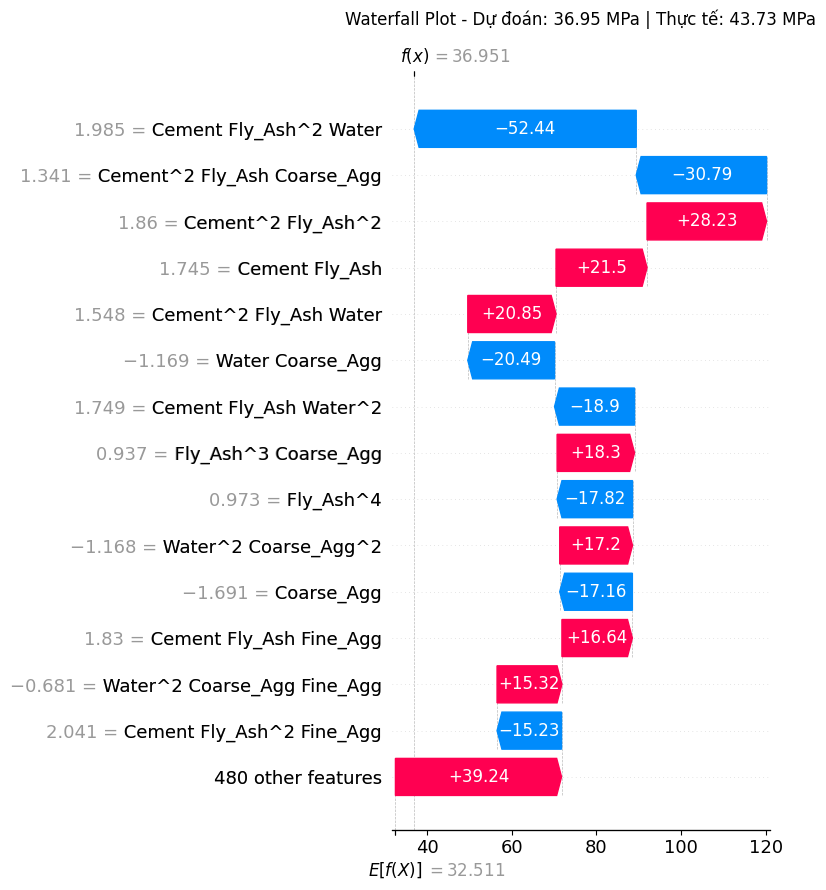

In [ ]:
# Chọn mẫu để giải thích (ví dụ: mẫu thứ 40)
sample_idx = 40

# Dự đoán cho mẫu đã chọn và lấy giá trị đầu tiên ([0]) từ kết quả
y_pred = best_ridge_model.predict(X_test_transform[[sample_idx]])[0]
y_true = y_test.iloc[sample_idx]

print(f"Mẫu #{sample_idx}: Dự đoán={y_pred:.2f} | Thực tế={y_true:.2f} MPa")

plt.figure(figsize=(12, 6))
shap.plots.waterfall(explanation[sample_idx], max_display=15, show=False)
plt.title(f"Waterfall Plot - Dự đoán: {y_pred:.2f} MPa | Thực tế: {y_true:.2f} MPa",
          fontsize=12, pad=15)
plt.tight_layout()
plt.show()

**Nhận xét với Mẫu #40**

- Dự đoán cho mẫu này bắt đầu từ giá trị cơ sở là **32.51 MPa**.
- Các đặc trưng như `Cement Fly_Ash^2 Water` (-52.44) và `Cement^2 Fly_Ash Coarse_Agg` (-30.79) có giá trị SHAP **âm** khá lớn đóng vai trò chính trong việc "kéo" dự đoán đi xuống.
- Ngược lại, các đặc trưng như `Cement^2 Fly_Ash^2` (+28.23), `Cement Fly_Ash` (+21.5) và `Cement Fly_Ash^2 Water` (+20.85) là những yếu tố chính "đẩy" dự đoán lên cao hơn.
- Tổng hợp tất cả các ảnh hưởng này, mô hình đưa ra dự đoán cuối cùng là **36.95 MPa**.

-----

### 8.4. Bar plot - Tầm quan trọng trung bình của các đặc trưng

Biểu đồ này tóm tắt tầm quan trọng của mỗi đặc trưng (feature importance) trên một tập hợp nhiều mẫu dữ liệu. Nó giúp xác định những yếu tố nào có ảnh hưởng lớn nhất đến dự đoán của mô hình một cách tổng quan

- Cách đọc biểu đồ:

| Thành phần | Vai trò & Khái niệm | Giải thích |
| :--- | :--- | :--- |
| **Trục Y** | Các Đặc trưng | Liệt kê tên của các đặc trưng, được sắp xếp theo thứ tự **quan trọng giảm dần** từ trên xuống. |
| **Trục X** | **Giá trị trung bình của |SHAP value|** | Biểu thị **mức độ ảnh hưởng trung bình** của mỗi đặc trưng. Giá trị càng lớn, đặc trưng càng quan trọng. |
| **Các Thanh** | Tầm quan trọng | Chiều dài của thanh tương ứng với giá trị trung bình của SHAP value tuyệt đối, cho thấy tầm quan trọng tổng thể của đặc trưng. |

/tmp/ipython-input-1005767985.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=feature_names_poly,


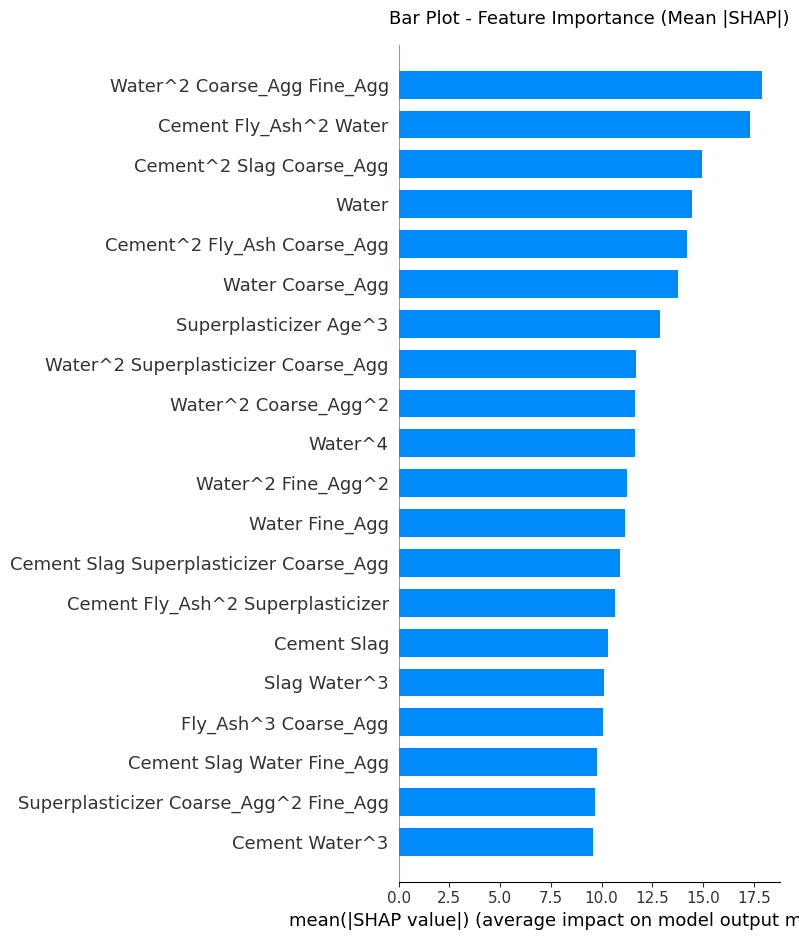


TOP 10 Features:
   1. Water^2 Coarse_Agg Fine_Agg    → 17.8885
   2. Cement Fly_Ash^2 Water         → 17.3173
   3. Cement^2 Slag Coarse_Agg       → 14.9652
   4. Water                          → 14.4591
   5. Cement^2 Fly_Ash Coarse_Agg    → 14.2041
   6. Water Coarse_Agg               → 13.7698
   7. Superplasticizer Age^3         → 12.8527
   8. Water^2 Superplasticizer Coarse_Agg → 11.6893
   9. Water^2 Coarse_Agg^2           → 11.6646
  10. Water^4                        → 11.6188


In [ ]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, feature_names=feature_names_poly,
                  plot_type="bar", max_display=20, show=False)
plt.title("Bar Plot - Feature Importance (Mean |SHAP|)", fontsize=13, pad=15)
plt.tight_layout()
plt.show()

# Top features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[-10:][::-1]
print("\nTOP 10 Features:")
for i, idx in enumerate(top_idx, 1):
    print(f"  {i:2d}. {feature_names_poly[idx]:30s} → {mean_abs_shap[idx]:.4f}")

**Nhận xét tổng quan**

- Điều nổi bật nhất là không có đặc trưng gốc nào đứng đầu danh sách. Tất cả các đặc trưng quan trọng nhất đều là các số hạng tương tác hoặc bậc cao.
- Điều này chứng tỏ mô hình Polynomial đã thành công trong việc học các mối quan hệ phi tuyến phức tạp giữa các thành phần mà mô hình đơn giản sẽ không thể nắm bắt được.
- `Water` và `Cement` xuất hiện rất nhiều trong các tương tác quan trọng cho thấy rõ sự quan trọng của chúng.
- Biểu đồ này cung cấp một cái nhìn tổng thể về những gì mô hình "quan tâm" nhất khi đưa ra dự đoán.

-----

### 8.5. Biểu đồ phân tán (Beeswarm Plot)

Biểu đồ này kết hợp tầm quan trọng của đặc trưng với **hướng và sự phân bố** của các tác động đó trên nhiều mẫu

- **Cách Đọc Biểu đồ Phân tán**

| Thành phần | Vai trò & Khái niệm | Giải thích |
| :--- | :--- | :--- |
| **Trục Y** | Các Đặc trưng | Được sắp xếp theo tầm quan trọng giảm dần từ trên xuống, tương tự như biểu đồ cột. |
| **Trục X** | Giá trị SHAP | Giá trị **dương** (bên phải) làm **tăng** dự đoán. Giá trị **âm** (bên trái) làm **giảm** dự đoán. |
| **Mỗi Điểm** | Một mẫu dữ liệu | Mỗi chấm trên biểu đồ tương ứng với một dự đoán cho một mẫu dữ liệu. |
| **Màu Sắc** | Giá trị của đặc trưng | **Màu đỏ** biểu thị giá trị **cao** của đặc trưng. **Màu xanh** biểu thị giá trị **thấp** của đặc trưng. |
| **Mật độ** | **Mật độ** | Tập trung càng dày cho thấy phần lớn dữ liệu với giá trị đặc trưng đó có tác động tương tự nhau và tác động đến đầu ra của mô hình. Ngược lại, thưa sẽ là ngoại lai hoặc trường hợp đặc biệt |



/tmp/ipython-input-4264209712.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transform[:n_samples],


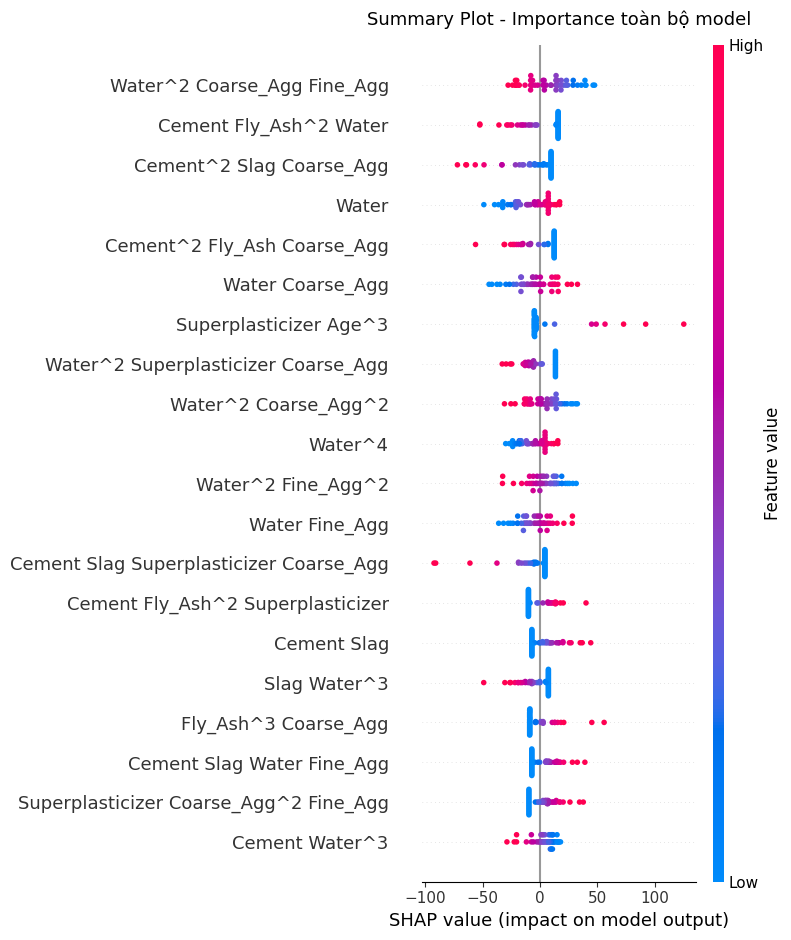

In [ ]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_transform[:n_samples],
                  feature_names=feature_names_poly, max_display=20, show=False)
plt.title("Summary Plot - Importance toàn bộ model", fontsize=13, pad=15)
plt.tight_layout()
plt.show()

**Nhận xét chi tiết**

- `Water^2 Coarse_Agg Fine_Agg`: Các điểm màu đỏ (giá trị đặc trưng cao) tập trung dày đặc ở phía giá trị SHAP **âm**. Ngược lại, các điểm màu xanh (giá trị đặc trưng thấp) nằm ở phía giá trị SHAP **dương**, cho thấy đây là đặc trưng có ảnh hưởng mạnh nhất đến mô hình theo mối quan hệ ngược chiều. Khi giá trị tương tác giữa nước và các loại cốt liệu tăng lên sẽ kéo dự đoán sức mạnh của bê tông xuống
- `Cement Fly_Ash^2 Water`: Tương tự như đặc trưng trên, các điểm màu đỏ (giá trị cao) có giá trị SHAP **âm rất mạnh**. Các điểm màu xanh (giá trị thấp) có giá trị SHAP dương. Mối quan hệ này cũng là ngược chiều, giá trị giữa xi măng, tro bay bậc 2 và nước làm giảm mạnh dự đoán. Mô hình cho rằng, việc kết hợp lượng lớn các thành phần này có thể gây hại cho sức bền của bê tông
- `Cement^2 Slag Coarse_Agg`: Cũng khá tương tự 2 trường hợp trên và đều thuộc **tương quan âm** rất mạnh và cũng sẽ làm giảm sức bền của bê tông nếu kết hợp với nhau

- Nhược điểm duy nhất là đa cộng tuyến, ví dụ như `Water^4` khá khó diễn giải, có thể gây ra overfitting tiềm ẩn

-----

### 8.6. Force plot - Biểu đồ lực (Cho 1 dự đoán cụ thể)

Biểu đồ lực cung cấp một cách nhìn khác về việc giải thích một dự đoán duy nhất, thể hiện các đóng góp như những "lực" cân bằng lẫn nhau

| Thành phần | Vai trò & Khái niệm | Giải thích |
| :--- | :--- | :--- |
| **Giá trị cơ sở (base value)** | Điểm cân bằng ban đầu | Giá trị dự đoán trung bình trên toàn bộ dữ liệu, là điểm khởi đầu của giải thích. |
| **Các khối/mũi tên Đỏ** | Lực đẩy (Positive SHAP values) | Các đặc trưng làm **tăng** giá trị dự đoán, "đẩy" kết quả lên cao hơn giá trị cơ sở. |
| **Các khối/mũi tên Xanh** | Lực kéo (Negative SHAP values) | Các đặc trưng làm **giảm** giá trị dự đoán, "kéo" kết quả xuống thấp hơn giá trị cơ sở. |
| **Giá trị đầu ra (output value)** | Điểm cân bằng cuối cùng | Giá trị dự đoán cuối cùng sau khi tất cả các lực đẩy và kéo được tổng hợp. |

In [ ]:
shap.initjs()
plt.figure(figsize=(30, 3))
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test_transform[sample_idx],
    feature_names=feature_names_poly,
)

-----

### 8.7. Biểu đồ phụ thuộc (Dependence plot)
Biểu đồ phụ thuộc giúp chúng ta hiểu hành vi của mô hình trên toàn cụcđối với một đặc trưng cụ thể. Nó trả lời hai câu hỏi quan trọng:
-  **Mối quan hệ chính:** Giá trị của một đặc trưng ảnh hưởng đến dự đoán như thế nào? (Tăng hay giảm, tuyến tính hay phức tạp?)
-  **Hiệu ứng tương tác:** Liệu ảnh hưởng của đặc trưng đó có thay đổi khi một đặc trưng khác thay đổi không?

- **Cách Đọc Biểu đồ Phụ thuộc**

| Thành phần | Vai trò & Khái niệm | Giải thích |
| :--- | :--- | :--- |
| **Trục X** | Giá trị của Đặc trưng chính | Hiển thị dải giá trị của đặc trưng đang được phân tích (ví dụ: lượng `Cement`, `Age`). |
| **Trục Y** | Giá trị SHAP của Đặc trưng chính | Cho thấy tác động của đặc trưng lên dự đoán. Giá trị > 0 làm **tăng** dự đoán, giá trị < 0 làm **giảm** dự đoán. |
| **Mỗi Điểm** | Một mẫu dữ liệu | Mỗi chấm trên biểu đồ tương ứng với một hàng trong tập dữ liệu được giải thích. |
| **Màu Sắc** | Giá trị của Đặc trưng Tương tác | Màu sắc của mỗi điểm được quyết định bởi giá trị của một đặc trưng khác mà SHAP cho là có tương tác mạnh nhất. **Màu đỏ** là giá trị **cao**, **màu xanh** là giá trị **thấp**. |
| **Phân bố Dọc** | Thể hiện hiệu ứng tương tác | Nếu các điểm tại một giá trị X nhất định bị phân tán theo trục Y, điều đó có nghĩa là ảnh hưởng của đặc trưng chính còn phụ thuộc vào giá trị của đặc trưng tương tác (màu sắc). |


🎯 Phân tích TOP 3 features gốc:

──────────────────────────────────────────────────────────────────────
#1. Water (Mean |SHAP|: 14.4591)
──────────────────────────────────────────────────────────────────────


<Figure size 3000x300 with 0 Axes>

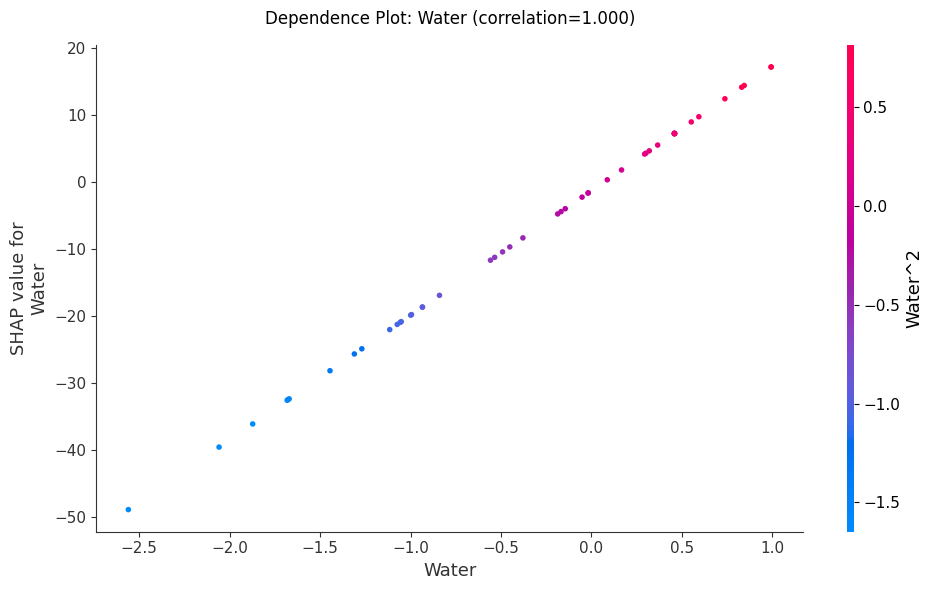

──────────────────────────────────────────────────────────────────────
#2. Cement (Mean |SHAP|: 8.9242)
──────────────────────────────────────────────────────────────────────


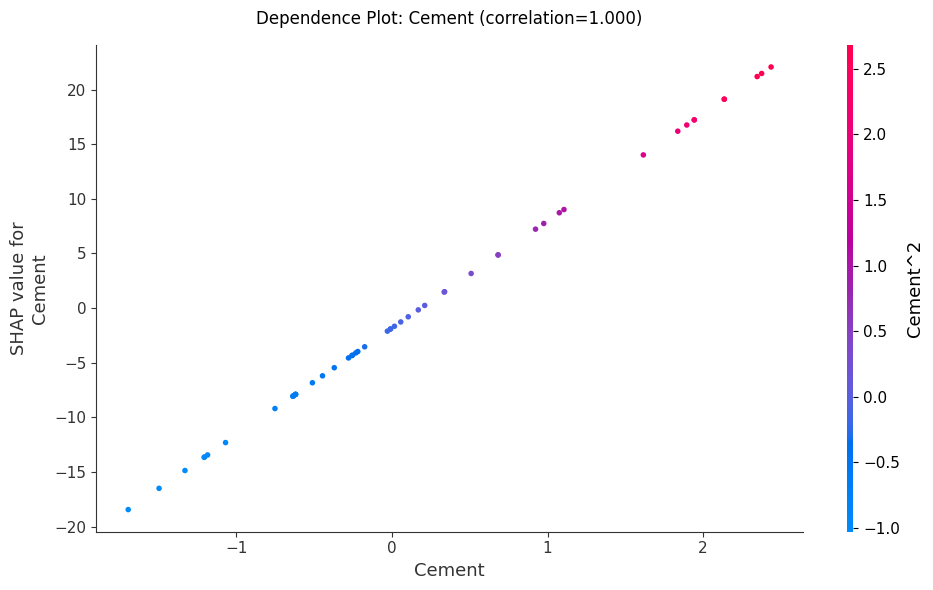

──────────────────────────────────────────────────────────────────────
#3. Coarse_Agg (Mean |SHAP|: 8.6435)
──────────────────────────────────────────────────────────────────────


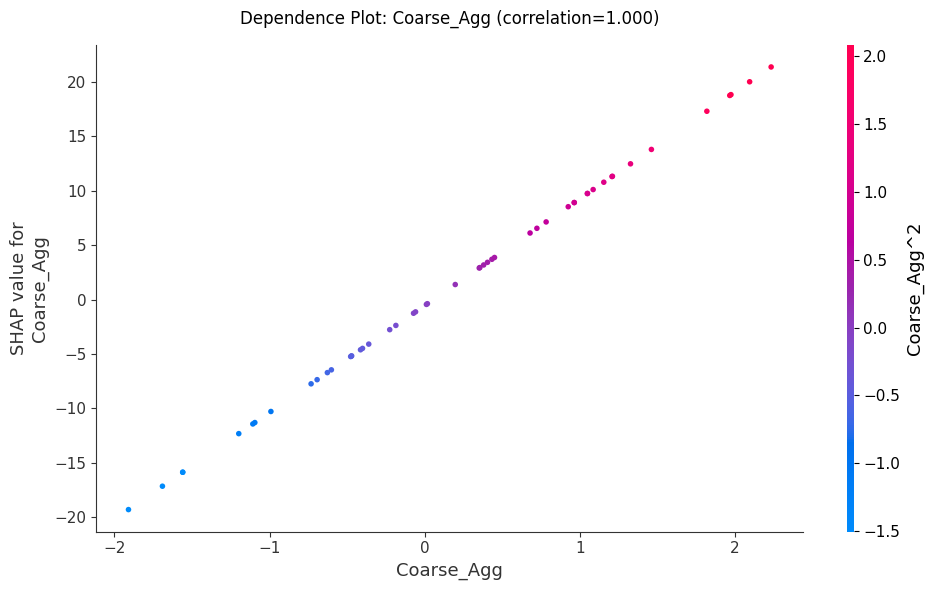

In [ ]:
# Lấy top 3 features GỐC quan trọng nhất
original_features = X_train.columns.tolist()
original_importance = {}
for feat in original_features:
    if feat in feature_names_poly:
        idx = list(feature_names_poly).index(feat)
        original_importance[feat] = np.abs(shap_values[:, idx]).mean()

top_3_orig = sorted(original_importance.items(), key=lambda x: x[1], reverse=True)[:3]

print("\n🎯 Phân tích TOP 3 features gốc:\n")

for rank, (feat_name, importance) in enumerate(top_3_orig, 1):
    print(f"{'─' * 70}")
    print(f"#{rank}. {feat_name} (Mean |SHAP|: {importance:.4f})")
    print(f"{'─' * 70}")

    feat_idx = list(feature_names_poly).index(feat_name)

    # Tính correlation
    feat_vals = X_test_transform[:n_samples, feat_idx]
    shap_vals = shap_values[:, feat_idx]
    corr = np.corrcoef(feat_vals, shap_vals)[0, 1]

    # Dependence plot
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.dependence_plot(
        feat_idx,
        shap_values,
        X_test_transform[:n_samples],
        feature_names=feature_names_poly,
        interaction_index="auto",
        ax=ax,
        show=False
    )
    plt.title(f"Dependence Plot: {feat_name} (correlation={corr:.3f})",
              fontsize=12, pad=15)
    plt.tight_layout()
    plt.show()

**Nhận xét từ các Biểu đồ**


**Water (Nước), Cement (Xi măng) và Coarse_Agg ()** Có mối quan hệ **tích cực rõ ràng**, khi các giá tỉ này càng nhiều sẽ giúp tăng giá tị dự đoán SHAP như càng nhiều nước, bê tông sẽ làm tăng dự đoán sức mạnh của bê tông
